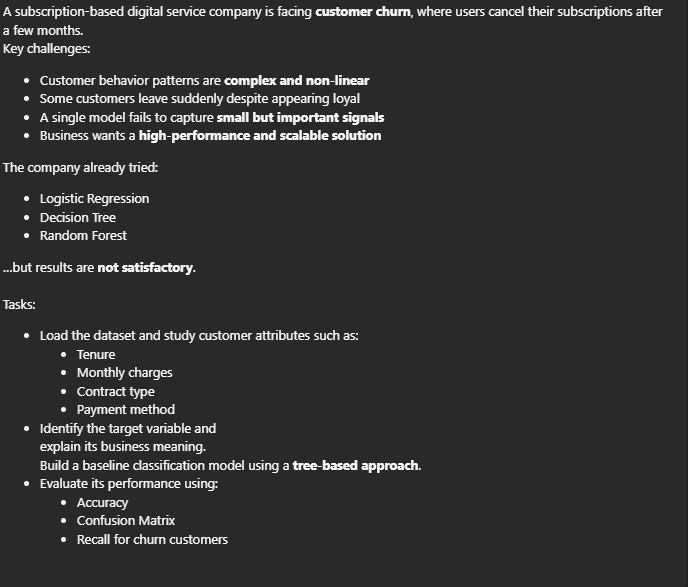

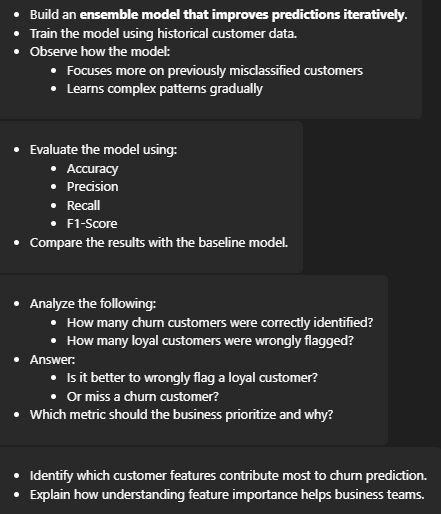

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


In [29]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define file path inside Google Drive
file_path = "/content/drive/MyDrive/Colab Notebooks/DataSets/WA_Fn-UseC_-Telco-Customer-Churn.csv"

# Read the CSV file
df = pd.read_csv(file_path)

# Display first few rows
print(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4         

In [30]:
# Q1. Study important customer attributes

selected_columns = [
    "tenure",
    "MonthlyCharges",
    "Contract",
    "PaymentMethod",
    "Churn"
]

df[selected_columns].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          7043 non-null   int64  
 1   MonthlyCharges  7043 non-null   float64
 2   Contract        7043 non-null   object 
 3   PaymentMethod   7043 non-null   object 
 4   Churn           7043 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 275.2+ KB


In [31]:
# Q2. Identify target variable and explain business meaning

# Convert target variable to binary
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

df["Churn"].value_counts()


,count
Churn,
0,5174
1,1869


In [32]:
# Q3. Data preprocessing

# Remove customerID (not useful for prediction)
df.drop("customerID", axis=1, inplace=True)

# Convert TotalCharges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Handle missing values
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# One-hot encode categorical features
df_encoded = pd.get_dummies(df, drop_first=True)

df_encoded.head()


/tmp/ipython-input-4145913843.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


In [33]:
# Q3. Split data into train and test sets

from sklearn.model_selection import train_test_split

X = df_encoded.drop("Churn", axis=1)
y = df_encoded["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [34]:
# Q4. Build baseline classification model using Decision Tree

from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(
    max_depth=5,
    random_state=42
)

dt_model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, random_state=42)

In [35]:
# Q4. Evaluate baseline model

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

y_pred_dt = dt_model.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
cm_dt = confusion_matrix(y_test, y_pred_dt)

accuracy_dt, recall_dt, cm_dt


(0.794180269694819,
 0.5454545454545454,
 array([[915, 120],
        [170, 204]]))

In [36]:
# Q5. Build ensemble model that focuses on misclassified customers

from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb_model.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,
                           random_state=42)

In [37]:
# Q6. Evaluate ensemble model

from sklearn.metrics import precision_score, f1_score

y_pred_gb = gb_model.predict(X_test)

accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)

accuracy_gb, precision_gb, recall_gb, f1_gb


(0.8026969481902059,
 0.6643835616438356,
 0.5187165775401069,
 0.5825825825825826)

In [38]:
# Q6. Compare baseline vs ensemble model

comparison = pd.DataFrame({
    "Model": ["Decision Tree", "Gradient Boosting"],
    "Accuracy": [accuracy_dt, accuracy_gb],
    "Recall (Churn)": [recall_dt, recall_gb]
})

comparison


,Model,Accuracy,Recall (Churn)
0,Decision Tree,0.794180,0.545455
1,Gradient Boosting,0.802697,0.518717


In [39]:
# Q7. Analyze churn identification

cm_gb = confusion_matrix(y_test, y_pred_gb)

tn, fp, fn, tp = cm_gb.ravel()

print("Correctly identified churn customers:", tp)
print("Wrongly flagged loyal customers:", fp)


Correctly identified churn customers: 194
Wrongly flagged loyal customers: 98


In [ ]:
# Q8. Business trade-off explanation (comment only)

"""
It is better to wrongly flag a loyal customer
than to miss a churn customer.

Reason:
- Flagging loyal customer → minor cost (offer/discount)
- Missing churn customer → permanent revenue loss
"""


In [ ]:
# Q9. Metric prioritization (comment only)

"""
Business should prioritize:
RECALL for churn customers

Why?
- Objective is to catch maximum potential churners
- Even if some loyal customers are flagged, business can afford retention offers
"""


In [40]:
# Q10. Identify important features contributing to churn

feature_importance = pd.Series(
    gb_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

feature_importance.head(10)


,0
tenure,0.290390
InternetService_Fiber optic,0.190370
PaymentMethod_Electronic check,0.126589
Contract_Two year,0.078992
TotalCharges,0.065339
Contract_One year,0.062071
MonthlyCharges,0.051887
PaperlessBilling_Yes,0.022904
OnlineSecurity_Yes,0.015290
TechSupport_Yes,0.012749


In [41]:
# Q10. Business value explanation (comment only)

"""
Understanding feature importance helps:
- Identify WHY customers churn
- Improve pricing strategies
- Optimize contract plans
- Design targeted retention campaigns
"""


'\nUnderstanding feature importance helps:\n- Identify WHY customers churn\n- Improve pricing strategies\n- Optimize contract plans\n- Design targeted retention campaigns\n'